# **Modulo de Clasificación de texto con BERT.**
### Usando Tensorflow.


## Pasos iniciales. 
### Instalación de bibliotecas y recursos necesarios para ejecutar **BERT**.

Para esta implementación estaremos utilizando esta dependencia para el preprocesamiento de los inputs de BERT. 

In [1]:
!pip install -q -U tensorflow-text

In [2]:
!pip install -q tf-models-official

Bibliotecas adicionales 

In [3]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [4]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import os 
import re
from tqdm import tqdm 
%matplotlib inline

Comenzamos a importar el Dataset. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd 'drive/MyDrive/DepresionDetection'

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1f7iqqmGVeLMWsZp_4v4rY02mGnyxDVS6/DepresionDetection


In [6]:
og_train_data = pd.read_csv('trans_text_train_BERT.csv')
og_test_data = pd.read_csv('trans_text_test_BERT.csv')

og_train_data = og_train_data.drop(['wav_file'], axis=1)
og_test_data = og_test_data.drop(['wav_file'], axis=1)

df = og_train_data.append(og_test_data, ignore_index = True)

df.head()

,label,transcription
0,2,we were very much younger then .
1,0,goddamn it augie don t ask me that . i hate it...
2,0,i would like to talk to your supervisor . obvi...
3,1,why didn t you let me know ?
4,3,i know .


In [7]:
emo_dict  = { 
  0: 'ang',
  1: 'hap',
  2: 'exc', 
  3: 'sad', 
  4: 'fru', 
  5: 'fea',
  6: 'sur',
  7: 'neu'
}
view_data = df.replace({'label': emo_dict})
view_data['label'].value_counts()

fru    1847
neu    1708
ang    1101
sad    1084
exc    1041
hap     595
sur     107
fea      40
Name: label, dtype: int64

In [8]:
def plot_data(_data,_bins,_title,_xlabel,_ylabel):
  TOTAL = 7523
  plt.figure(figsize=(20,10))
  arr = plt.hist(_data, bins=_bins, edgecolor='black', alpha=0.5, align='mid')
  for i in range(_bins):
    count = int(arr[0][i])
    if count != 0:
      plt.text(arr[1][i] + 0.1, arr[0][i], str(count), fontsize=15, rotation=-45)
  plt.xlabel(_xlabel, fontsize=15)
  plt.ylabel(_ylabel, fontsize=15)
  plt.title(_title, fontsize=20, pad=40)
  plt.grid(False)
  plt.show()

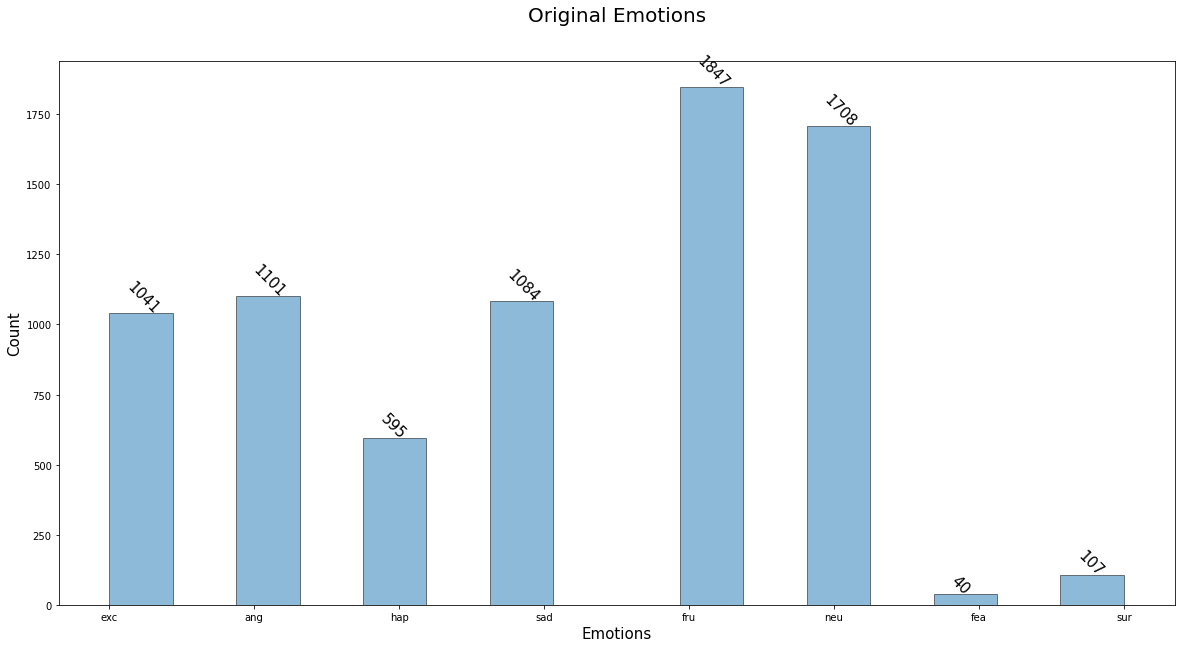

In [9]:
plot_data(view_data.label, 16, "Original Emotions", "Emotions", "Count")

In [10]:
# Procedemos a condensar las partes relevantes del dataset. 
emo_dict_2  = { 
  0: 'neg',
  1: 'pos',
  2: 'pos', 
  3: 'neg', 
  4: 'neg', 
  5: 'neg',
  6: 'pos',
  7: 'pos'
}
view_data2 = df.replace({'label': emo_dict_2})
view_data2['label'].value_counts()

neg    4072
pos    3451
Name: label, dtype: int64

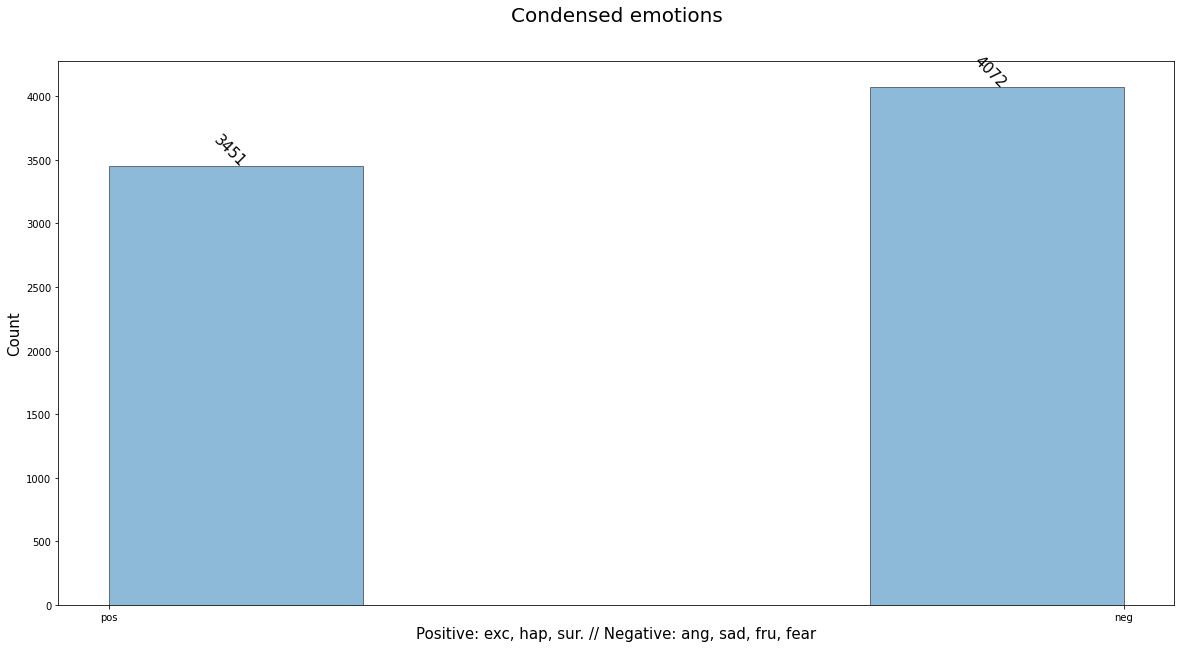

In [11]:
plot_data(view_data2.label, 4, "Condensed emotions", "Positive: exc, hap, sur. // Negative: ang, sad, fru, fear", "Count")

In [12]:
df_clean = view_data2.replace(to_replace ="neg",
                 value =0)

In [13]:
df_clean2 = df_clean.replace(to_replace ="pos",
                 value =1)

In [14]:
df_clean2.head()

,label,transcription
0,1,we were very much younger then .
1,0,goddamn it augie don t ask me that . i hate it...
2,0,i would like to talk to your supervisor . obvi...
3,1,why didn t you let me know ?
4,0,i know .


In [36]:
new_whole_ds = pd.read_csv('/content/drive/MyDrive/DepresionDetection/full_augmented_text.csv')
new_whole_ds.head()

,label,transcription
0,0,goddamn it augie don t ask me that . i hate it...
1,0,i would like to talk to your supervisor . obvi...
2,0,i know .
3,0,you never did .
4,0,to hell with that !


Distribución de los datos post data Agumentation. 

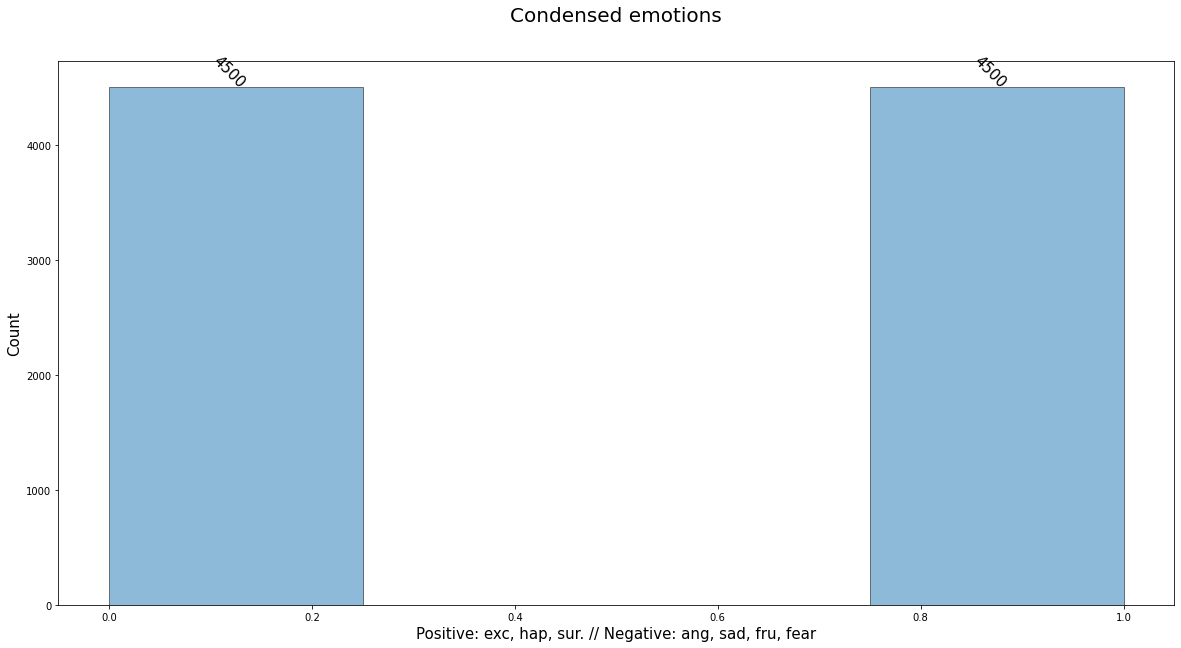

In [37]:
plot_data(new_whole_ds.label, 4, "Condensed emotions", "Positive: exc, hap, sur. // Negative: ang, sad, fru, fear", "Count")

Aquí hacemos la división para los datasets, obteniendo un test de entrenamiento y uno de prueba. Los archivos correspondientes a cada set y su clase son guardados en la carpeta con el tipo de set ('train' o 'test') y la clase de los datos para cada set ('0' para negativos, '1' para positivos). 

In [38]:
sentences = new_whole_ds.transcription.values
labels = new_whole_ds.label.values

from sklearn.model_selection import train_test_split

# Usamos 90% para entrenamiento y 10% para testing.
train_inputs, test_inputs, train_labels, test_labels = train_test_split(sentences, labels, random_state=2018, test_size=0.1)

# Listas para guardar los valores de las etiquetas. 

in_0_train = []
in_1_train = []

in_0_test = []
in_1_test = []

print("Número de datos en Dataset de entrenamiento:")
print(len(train_labels))
print("Número de datos en Dataset de prueba.")
print(len(test_labels))

# Procedemos a checar los valores de las etiquetas (Entrenamiento). 
for item in range(len(train_labels)):
  if train_labels[item]== 0:
    f = open(f"/content/drive/MyDrive/DepresionDetection/AugDatasets_TF/train/0/{item}.txt", "w+")
    f.write(train_inputs[item])
    f.close()
  elif train_labels[item] == 1:
    f = open(f"/content/drive/MyDrive/DepresionDetection/AugDatasets_TF/train/1/{item}.txt", "w+")
    f.write(train_inputs[item])
    f.close()

# Procedemos a checar los valores de las etiquetas (Testing). 
for item in range(len(test_labels)):
  if test_labels[item]== 0:
    f = open(f"/content/drive/MyDrive/DepresionDetection/AugDatasets_TF/test/0/{item}.txt", "w+")
    f.write(test_inputs[item])
    f.close()
  elif test_labels[item] == 1:
    f = open(f"/content/drive/MyDrive/DepresionDetection/AugDatasets_TF/test/1/{item}.txt", "w+")
    f.write(test_inputs[item])
    f.close()


    #train_inputs[item].to_numpy()
    #np.savetxt("/content/drive/MyDrive/DS/train.txt", numpy_array, fmt = "%d")



Número de datos en Dataset de entrenamiento:
8100
Número de datos en Dataset de prueba.
900


In [39]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/drive/MyDrive/DepresionDetection/AugDatasets_TF/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/drive/MyDrive/DepresionDetection/AugDatasets_TF/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/drive/MyDrive/DepresionDetection/AugDatasets_TF/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 8978 files belonging to 2 classes.
Using 7183 files for training.
Found 8978 files belonging to 2 classes.
Using 1795 files for validation.
Found 1112 files belonging to 2 classes.


Después de realizar la separación de los datos originales, se procede a agarrar algunos al azahar para visualizar su clasificación. 

In [40]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'who you always use your driver s license . i mean you re not coming to the d .m .v . if you re not over sixteen and that s when you get your driver s license so you re never gonna need it anyway .'
Label : 0 (0)
Review: b'well i got an idea . but what s the story ?'
Label : 1 (1)
Review: b'right i know like you it won t hurt i mean national champions last year wow you know'
Label : 1 (1)


Escogimos el siguiente modelo de Bert para pre procesamiento: 

```bert_en_uncased_L-12_H-768_A-12/3``` 

Debido a que en el caso de este set de entrenamiento, las mayúsculas no son extremadamente importantes. 




In [41]:
# Bert model and preprocessing to be used:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3' 
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [23]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Ejemplo del uso del encoding con BERT. 

In [42]:
text_test = ['I feel awful, I want this to end.']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1045 2514 9643 1010 1045 2215 2023 2000 2203 1012  102]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


Comenzamos a usar el modelo. 

In [43]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

3 Claves importantes son devueltas por los modelos BERT, las cuales podemos observar para comprobar su funcionamiento. 

*   pooled_output: representa cada secuencia de la entrada como una unidad. Su forma es  ```[batch_size, H] ```.


*   sequence_output: representa cada uno de los tokens de entrada en el contexto. Su forma es ```[batch_size, seq_length, H] ```.
*   encoder_outputs: son las actividades intermedias de los bloques L Transformer. ```outputs["encoder_outputs"][i] ```. consta de un tensor de forma ```[batch_size, seq_length, 1024] ``` con las salidas del i-ésimo bloque Transformer, para ```0 <= i < L ```. El último valor de la lista es equivalente a ```sequence_output```.

En el proceso de fine tuning, se utiliza la matriz ```pooled_output```.



In [27]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Pooled Outputs Shape:(1, 768)
Pooled Outputs Values:[-0.8104963  -0.30172354 -0.8092313   0.61915314  0.35248485 -0.16918992
  0.5349199   0.21368246 -0.74848086 -0.9997207   0.03820153  0.95563823]
Sequence Outputs Shape:(1, 128, 768)
Sequence Outputs Values:[[ 0.06142963  0.49400946  0.00443552 ... -0.2966762   0.23155878
   0.51421356]
 [ 0.31538638  0.6333135  -0.7207377  ... -0.06407636  0.77999246
   0.7276976 ]
 [-0.251095    1.2244781   0.38318416 ... -0.06314597 -0.21555732
   1.1825062 ]
 ...
 [ 0.13107018 -0.70477504 -0.09237924 ...  0.12566827 -0.20308088
  -0.28534472]
 [ 0.42630446  0.18120922 -0.38756078 ... -0.39387578 -0.2241484
  -0.54518753]
 [-0.29964474  0.23803145  0.11242712 ...  0.35597908 -0.24906395
  -0.00709724]]


Hacemos nuestra función para construir el modelo. 

In [44]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Confirmamos que corra con la salida del modelo del preprocesamiento. 

In [45]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.3676924]], shape=(1, 1), dtype=float32)


Por el momento la salida es irrelevante, ya que no ha sido entrenado. 

Visualizamos la estructura del modelo. 

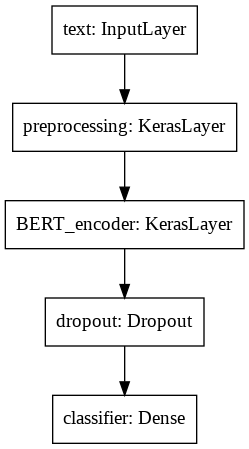

In [20]:
tf.keras.utils.plot_model(classifier_model)

## Entrenamiento

### Función de costo. 
Debido a que es un problema de clasificación y trabajamos con clases binarias, utilizaremos 
```losses.BinaryCrossentropy```.



In [46]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

In [47]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [48]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [49]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3
Epoch 1/5
225/225 [==============================] - 237s 989ms/step - loss: 0.6129 - binary_accuracy: 0.6425 - val_loss: 0.5487 - val_binary_accuracy: 0.7460
Epoch 2/5
225/225 [==============================] - 212s 943ms/step - loss: 0.3986 - binary_accuracy: 0.8123 - val_loss: 0.5160 - val_binary_accuracy: 0.8017
Epoch 3/5
225/225 [==============================] - 212s 943ms/step - loss: 0.2557 - binary_accuracy: 0.8920 - val_loss: 0.5416 - val_binary_accuracy: 0.8061
Epoch 4/5
225/225 [==============================] - 212s 944ms/step - loss: 0.1885 - binary_accuracy: 0.9258 - val_loss: 0.5699 - val_binary_accuracy: 0.8089
Epoch 5/5
225/225 [==============================] - 212s 944ms/step - loss: 0.1452 - binary_accuracy: 0.9414 - val_loss: 0.6057 - val_binary_accuracy: 0.8178


In [50]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

35/35 [==============================] - 46s 993ms/step - loss: 0.5553 - binary_accuracy: 0.8282
Loss: 0.5553234815597534
Accuracy: 0.8282374143600464


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


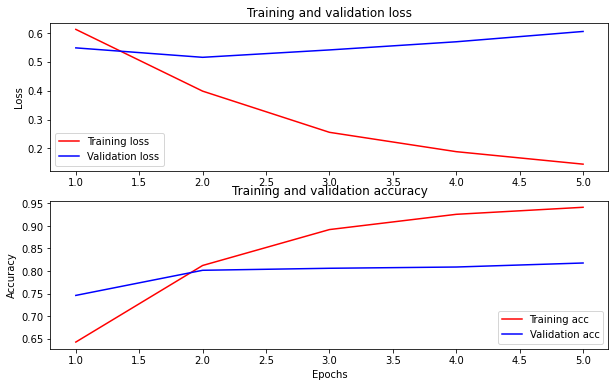

In [52]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')


In [53]:
dataset_name = 'IEMOCAP_Dat_Aug_2'
saved_model_path = '/content/drive/MyDrive/DepresionDetection/BertModel/{}_bert'.format(dataset_name.replace('/', '_'))



In [54]:
classifier_model.save(saved_model_path, include_optimizer=False)

In [55]:
reloaded_model = tf.saved_model.load(saved_model_path)

En caso de querer entrenar el modelo de nuevo. La siguiente opción permite usar un modelo en memoria y un modelo preentrenado cargado desde una ruta especificada. (Para este caso, el modelo en memoria y el guardado son el mismo modelo).

Se aprecian buenas predicciones en base a las oraciones introducidas. 

Entre más cercana a 0, más negativa la emoción y entre más cercana a 1, más positiva. 

In [58]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'I do not feel so good',  # this is the same sentence tried earlier
    'I had a great day',
    'I wish I were dead.',
    'I cannot bear the pain anymore.',
    'You make me really happy.'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: I do not feel so good          : score: 0.017642
input: I had a great day              : score: 0.988528
input: I wish I were dead.            : score: 0.010432
input: I cannot bear the pain anymore. : score: 0.007843
input: You make me really happy.      : score: 0.995693

Results from the model in memory:
input: I do not feel so good          : score: 0.017642
input: I had a great day              : score: 0.988528
input: I wish I were dead.            : score: 0.010432
input: I cannot bear the pain anymore. : score: 0.007843
input: You make me really happy.      : score: 0.995693

